In [1]:
# loading required packeges
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘infer’ was built under R version 4.0.2”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

 

In [2]:
# downloading and cleaning data
league_20_21 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/2021/E0.csv') %>% 
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>% 
    select(goal_diff)

league_19_20 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1920/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>%
    select(goal_diff)

league_17_18 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1718/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>% 
    select(goal_diff)

league_16_17 <- 
    read.csv('https://www.football-data.co.uk/mmz4281/1617/E0.csv') %>% 
    select(Date, HomeTeam, AwayTeam, FTHG, FTAG) %>%
    filter(HomeTeam == 'Man United' | AwayTeam == 'Man United') %>%
    mutate(goal_diff = (FTHG - FTAG) * (HomeTeam == 'Man United') +
              (FTAG - FTHG) * (AwayTeam == 'Man United')) %>%
    select(goal_diff)

In [3]:
# Sort and summarize the statistics of each coach
old_coach <- rbind(league_16_17, league_17_18) %>% 
    mutate(result = case_when(goal_diff < 0 ~ 'Lose', goal_diff == 0 ~ 'Draw', goal_diff > 0 ~ 'Win'), 
        coach = 'old') 

new_coach <- rbind(league_19_20, league_20_21) %>% 
    mutate(result = case_when(goal_diff < 0 ~ 'Lose', goal_diff == 0 ~ 'Draw', goal_diff > 0 ~ 'Win'), 
        coach = 'new')


league_results <- rbind(old_coach, new_coach)
head(league_results)

,goal_diff,result,coach
,<int>,<chr>,<chr>
1,2,Win,old
2,2,Win,old
3,1,Win,old
4,-1,Lose,old
5,-2,Lose,old
6,3,Win,old


### Statistics and distribution

In [4]:
# find observed statistics for each parameter
obs_stat <- league_results %>%
    group_by(coach) %>%
    summarize(mean = mean(goal_diff) %>% round(3), 
             sd = sd(goal_diff) %>% round(3), 
             n = n())
obs_stat

# find obersed difference
# in standard deviations
obs_diff_sd <- obs_stat$sd[1] - obs_stat$sd[2]
paste("Standard deviation of difference in goals: ", obs_diff_sd)
# in means
obs_diff_mean <- obs_stat$mean[1] - obs_stat$mean[2]
paste('Mean of difference in goals: ', obs_diff_mean)

`summarise()` ungrouping output (override with `.groups` argument)



coach,mean,sd,n
<chr>,<dbl>,<dbl>,<int>
new,0.776,1.916,76
old,0.855,1.538,76


[1] "Standard deviation of difference in goals:  0.378"

[1] "Mean of difference in goals:  -0.079"

Warning message:
“Removed 12 rows containing missing values (geom_bar).”


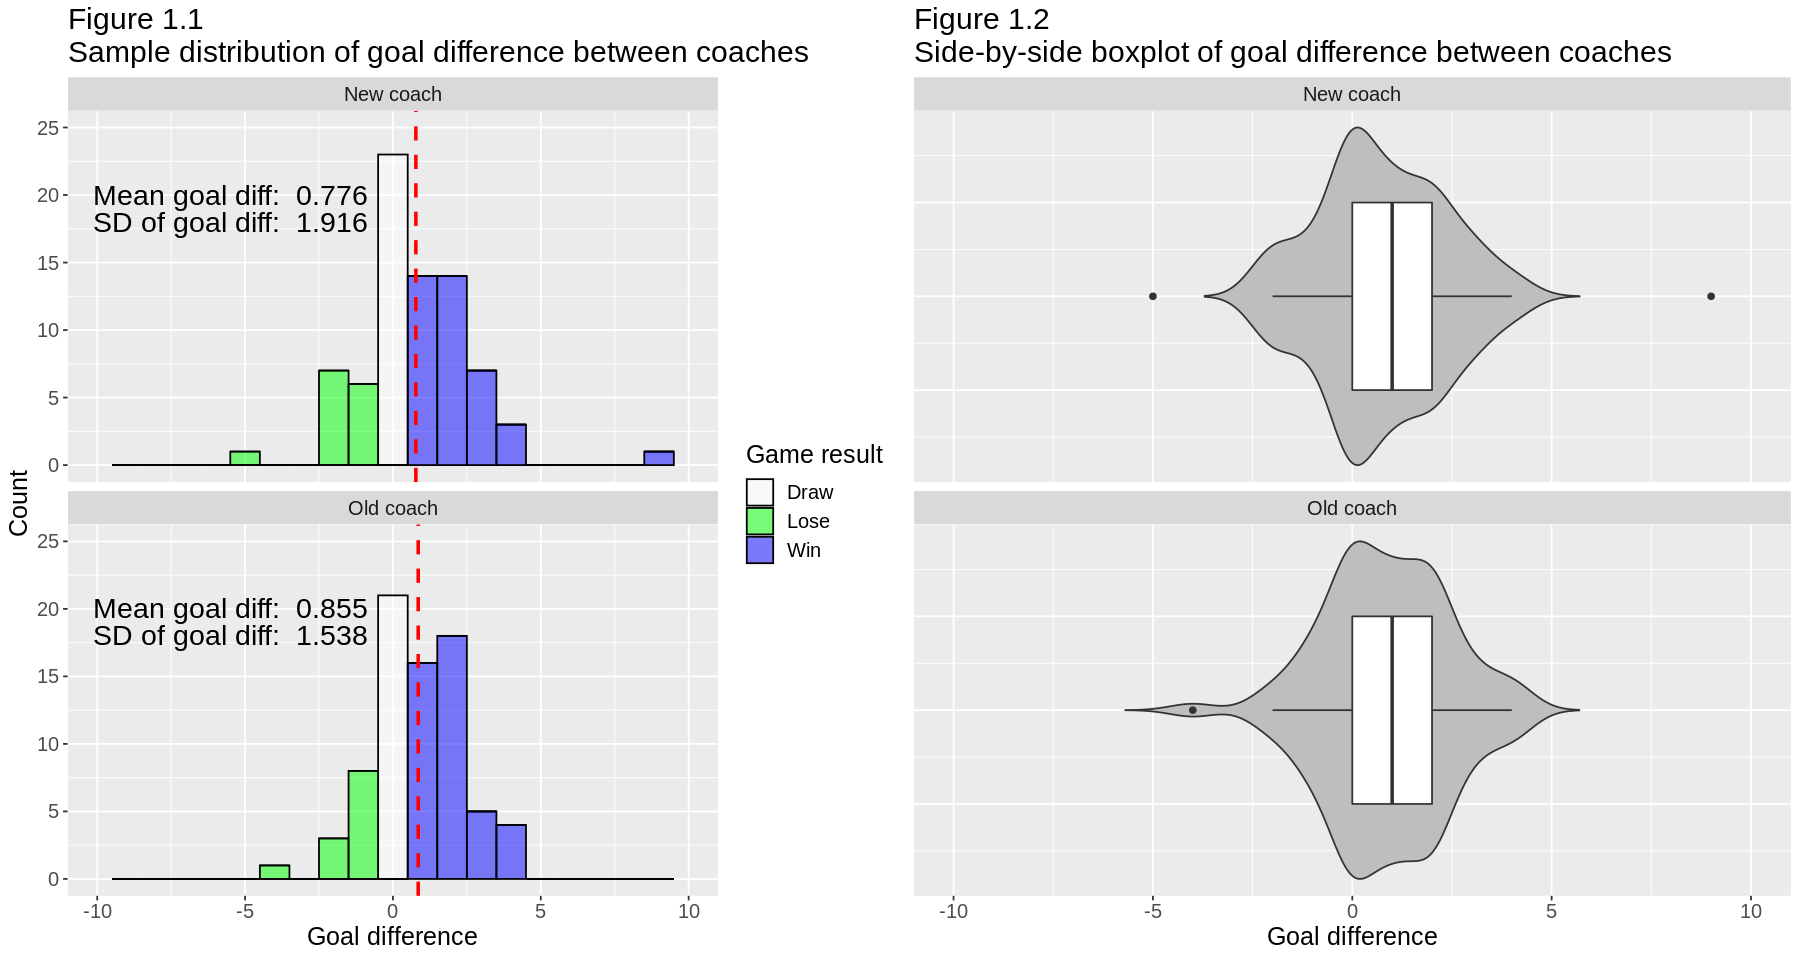

In [5]:
# construct sample distribution
goal_diff_sample_distribution <- 
    league_results %>%   
    ggplot() +
    geom_histogram(aes(x = goal_diff, fill = result), color = "black", binwidth = 1, alpha=0.5) +
    scale_fill_manual(values=c('white', 'green', 'blue')) +
    labs(x = "Goal difference", fill='Game result', y='Count') + 
    lims(x=c(-10, 10), y=c(0, 25)) +
    ggtitle("Figure 1.1\nSample distribution of goal difference between coaches") +
    theme(text = element_text(size = 15)) +
    facet_wrap(~coach, labeller=as_labeller(c('new'='New coach', old='Old coach')), nrow=2, ncol=1) +
    geom_vline(data=data.frame(coach='new'), 
               aes(xintercept = obs_stat$mean[1]), color = "red", linetype = "dashed", size = 1) + 
    geom_text(data=data.frame(coach='new'), 
              x = -5.5, y = 20, label = paste("Mean goal diff: ", obs_stat$mean[1]), size = 6) +
    geom_text(data=data.frame(coach='new'), 
              x = -5.5, y = 18, label = paste("SD of goal diff: ", obs_stat$sd[1]), size = 6) +
    geom_vline(data=data.frame(coach='old'), 
               aes(xintercept = obs_stat$mean[2]), color = "red", linetype = "dashed", size = 1) + 
    geom_text(data=data.frame(coach='old'), 
              x = -5.5, y = 20, label = paste("Mean goal diff: ", obs_stat$mean[2]), size = 6) +
    geom_text(data=data.frame(coach='old'), 
              x = -5.5, y = 18, label = paste("SD of goal diff: ", obs_stat$sd[2]), size = 6)

league_results_no_outliers <- 
    league_results %>%
    filter(goal_diff < 5 & goal_diff > -5)

goal_diff_box <- league_results %>% 
    ggplot() +
    geom_violin(data=league_results_no_outliers, aes(x=0, y=goal_diff), trim = FALSE, fill='grey') +
    geom_boxplot(aes(y=goal_diff), width=0.5) +
    theme(axis.title.y=element_blank(), axis.text.y=element_blank(), axis.ticks.y=element_blank(), 
             text = element_text(size=15)) +
    coord_flip() +
    lims(y=c(-10, 10)) +
    facet_wrap(~coach, nrow=2, ncol=1, labeller=as_labeller(c('new'='New coach', old='Old coach'))) +
    ggtitle('Figure 1.2\nSide-by-side boxplot of goal difference between coaches') +
    ylab('Goal difference')

options(repr.plot.width = 15, repr.plot.height = 8)
plot_grid(goal_diff_sample_distribution, goal_diff_box)

### Hypothesis testing

In [6]:
# hypothesis testing: bootstrap
# infer package abstracts the bootstrap process in `generate()`
set.seed(2001)

# construct null model
null_dist_bt <- 
    league_results %>%
    specify(formula = goal_diff ~ coach) %>%
    hypothesize(null = 'independence') %>%
    generate(reps = 1000, type = 'permute') %>%
    calculate(stat = 'diff in means', order = c('new', 'old'))
head(null_dist_bt)

# obtain p-value
p_value_bt <- null_dist_bt %>% 
    get_p_value(obs_stat=obs_diff_mean, direction='right')
paste('p-value from bootstrapping: ', p_value_bt)

replicate,stat
<int>,<dbl>
1,0.15789474
2,-0.42105263
3,-0.36842105
4,-0.23684211
5,-0.15789474
6,0.07894737


[1] "p-value from bootstrapping:  0.646"

NULL

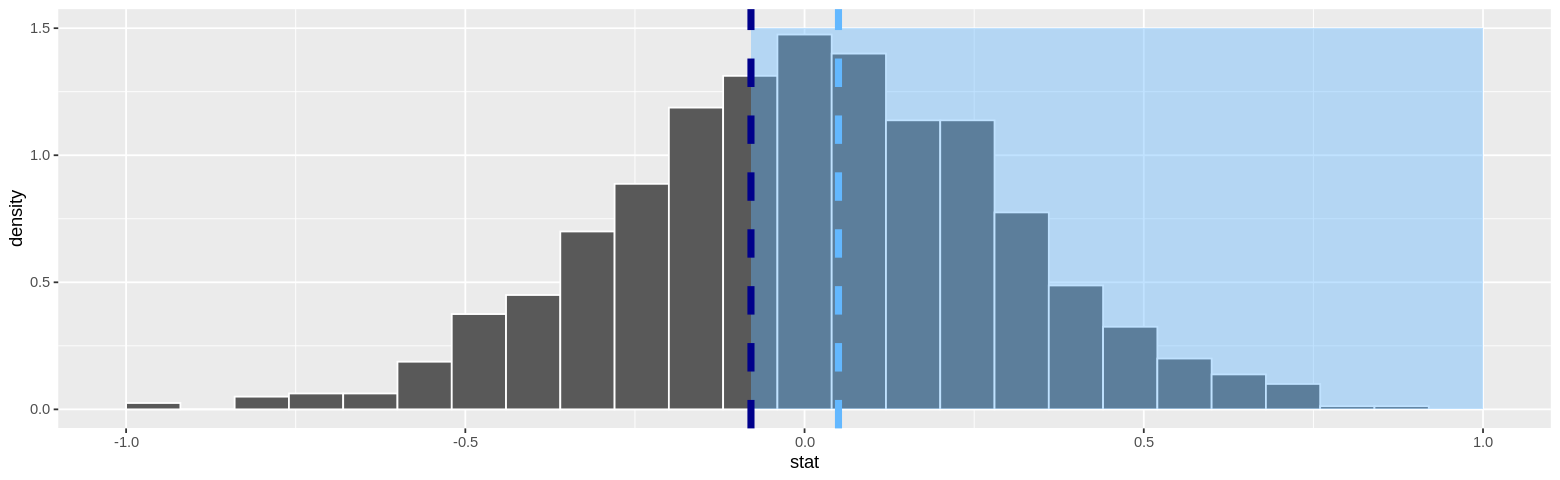

In [7]:
# visualize the null model obtained from bootsrtapping
# shade observed difference + significance level
colors <- c(l1 = "blue4", "Significance level" = "steelblue1")

null_dist <- ggplot() +
    geom_histogram(data=null_dist_bt, aes(x=stat, y=..density..), binwidth=0.08, color='white') +
    geom_rect(aes(xmin=obs_diff_mean, xmax=1, ymin=0, ymax=1.5), fill='steelblue1', alpha=0.4) +
    geom_vline(aes(xintercept=obs_diff_mean), size=2, color='blue4', linetype='dashed') +
    geom_vline(aes(xintercept=0.05), size=2, color='steelblue1', linetype='dashed')
    labs(title='Figure 2.1\nSimulation-based null distribution of goal difference',
            x='Mean goal difference', 
            y='Density') +
    scale_color_manual(values=colors)

options(repr.plot.width = 13, repr.plot.height = 4)
null_dist

In [8]:
# hypothesis testing: asymptotics

# standard errors
obs_diff_se <- sqrt(obs_stat$sd[1]^2 / obs_stat$n[1] + obs_stat$sd[2]^2 / obs_stat$n[2])

# test statistic
ts <- obs_diff_mean / obs_diff_se

# degrees of freedom
v = (obs_stat$sd[1]^2 / obs_stat$n[1] + obs_stat$sd[2]^2 / obs_stat$n[2])^2 / 
    (obs_stat$sd[1]^4 / (obs_stat$n[1]^2*(obs_stat$n[1]-1)) + 
     obs_stat$sd[2]^4 / (obs_stat$n[2]^2*(obs_stat$n[2]-1)))
# obtain p-value
p_value_as <- pt(ts, df=v, lower.tail = FALSE)
paste('p-value from two-sample t-test: ', p_value_as %>% round(4))

[1] "p-value from two-sample t-test:  0.6102"

In [9]:
# plots to add: compare sample distribution (new_coach) with normal distribution line; compare sample distribution (old_coach) with normal distribution line

To conclude what we have done in this sub-section so far:
- We obtained the p-value from **bootstrapping**: $p=0.646>0.05$. Therefore, we do not reject the null hypothesis $H_0$.
- We obtained the p-value from **bootstrapping**: $p=0.6102>0.05$. Again, the test result suggests that $H_0$ would not be rejected. 
- According to *Figure 2.1*, in the null model we construct, the observed mean difference (dark-blue dashed line) lies at a less extreme position than our level of rejection at a 0.05 significance level. Hence there is insufficient evidence to reject $H_0$.

### Condifence interval

In [10]:
set.seed(2001)

# take bootstrap samples from the original dataset and calculate the parameters
bs <- league_results %>%
    select(goal_diff, coach) %>%
    rep_sample_n(size=obs_stat$n[1]+obs_stat$n[2], reps=1000, replace=TRUE) %>%
    group_by(replicate, coach) %>%
    summarize(mean=mean(goal_diff), sd=sd(goal_diff), n=n())
new_bs <- bs %>% filter(coach == 'new') %>% select(-coach)
colnames(new_bs) <- c('replicate', 'new_mean', 'new_sd', 'new_n')
old_bs <- bs %>% filter(coach == 'old') %>% select(-coach)
colnames(old_bs) <- c('replicate', 'old_mean', 'old_sd', 'old_n')

# construct a 95% confidence interval
goal_diff_ci <- new_bs %>% 
    left_join(old_bs) %>%
    mutate(goal_diff_mean = new_mean-old_mean, 
           goal_diff_se = sqrt(new_sd^2/new_n + old_sd^2/old_n), 
           v = (new_sd^2 / new_n + old_sd^2 / old_n)^2 / 
             (new_sd^4 / (new_n^2*(new_n-1)) + old_sd^4 / (old_n^2*(old_n-1))), 
           lower_ci = goal_diff_mean + goal_diff_se*qt(0.025, df=v), 
           upper_ci = goal_diff_mean + goal_diff_se*qt(0.975, df=v), 
           captured = lower_ci<0 & upper_ci>0) %>%
    select(replicate, lower_ci, upper_ci, captured)

head(goal_diff_ci)

`summarise()` regrouping output by 'replicate' (override with `.groups` argument)

Joining, by = "replicate"



replicate,lower_ci,upper_ci,captured
<int>,<dbl>,<dbl>,<lgl>
1,-1.0402227,0.2062808,TRUE
2,-0.5131486,0.6505693,TRUE
3,-0.2787815,0.7954482,TRUE
4,-0.9325024,0.0781301,TRUE
5,-0.4579528,0.7294978,TRUE
6,-0.6651356,0.4143986,TRUE


replicate,stat
<int>,<dbl>
1,-0.32011824
2,0.29722222
3,-0.15789474
4,0.02130682
5,0.11267606
6,-0.07993758


lower_ci,upper_ci
<dbl>,<dbl>
-0.6871443,0.4574337


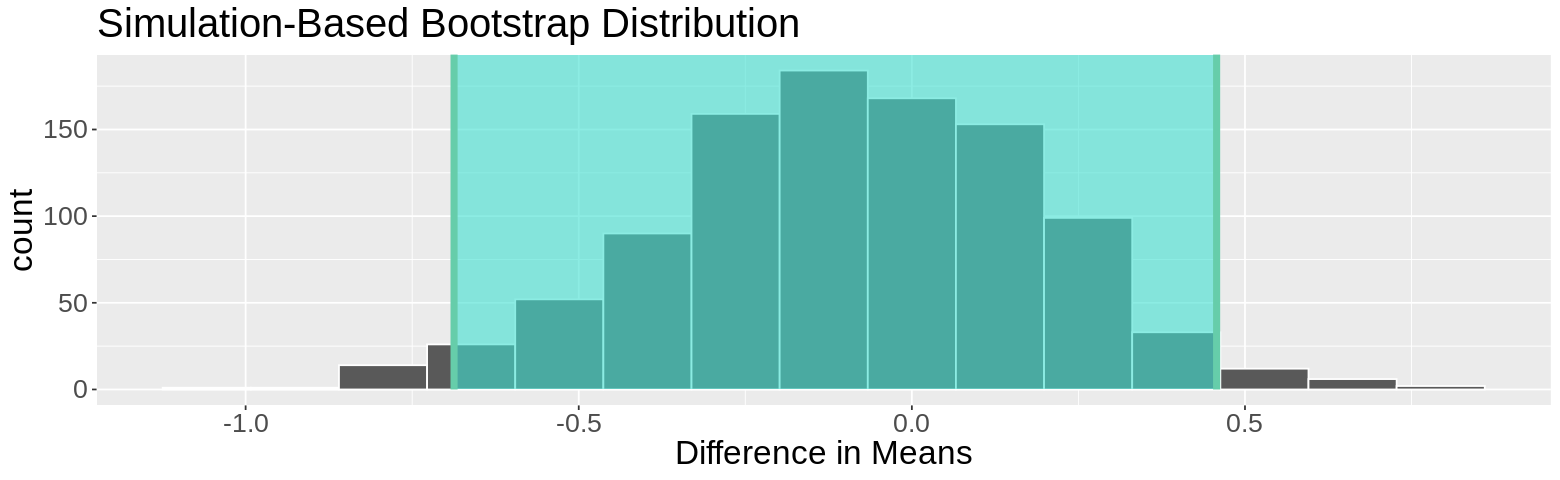

In [11]:
# CI using bootstrap (refer to tutorial 6 2.11-2.13)
diff_in_means_bootstrap_dist <- 
    league_results %>%
    specify(formula = goal_diff ~ coach) %>%
    generate(reps = 1000, type = 'bootstrap') %>%
    calculate(stat = 'diff in means', order = c('new', 'old'))

diff_in_means_ci <- 
    diff_in_means_bootstrap_dist %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

diff_in_means_ci_plot <-
    visualize(diff_in_means_bootstrap_dist) + 
    shade_confidence_interval(endpoints = diff_in_means_ci) + 
    theme(text = element_text(size = 20)) + 
    xlab("Difference in Means")

head(diff_in_means_bootstrap_dist)
diff_in_means_ci
diff_in_means_ci_plot

In [12]:
# CI based on CLT (refer to tutorial 7 2.3)
new_mean <- obs_stat$mean[1]
old_mean <- obs_stat$mean[2]
new_var <- obs_stat$sd[1]^2
old_var <- obs_stat$sd[2]^2

mean_clt_ci <- 
    tibble(lower_ci = (new_mean - old_mean + qnorm(0.05) * sqrt(new_var/76 + old_var/76)),
           upper_ci = (new_mean - old_mean + qnorm(0.95) * sqrt(new_var/76 + old_var/76)))

mean_clt_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.5425676,0.3845676


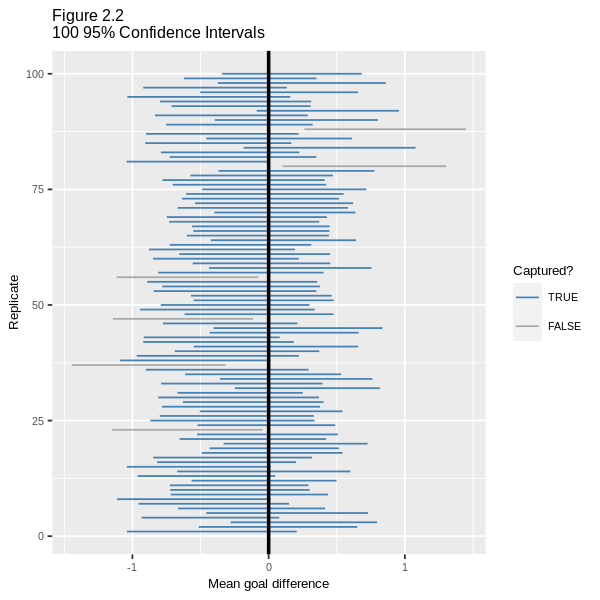

In [13]:
# plot the first 100 confidence intervals over the hypothesized mean goal difference
goal_diff_ci_plot <- goal_diff_ci %>% 
    head(100) %>%
    ggplot() +
    scale_colour_manual(breaks = c("TRUE", "FALSE"),
                        values = c("steelblue", "darkgrey")) +
    geom_segment(aes(x = lower_ci,
                     xend = upper_ci,
                     y = replicate,
                     yend = replicate,
                     colour = captured)) +
    geom_vline(xintercept = 0, colour = "black", size = 1) +
    labs(title = "Figure 2.2\n100 95% Confidence Intervals",
         x = 'Mean goal difference',
         y = "Replicate",
         colour = "Captured?") +
    theme(text = element_text(size = 8)) 


options(repr.plot.width = 5, repr.plot.height = 5)
goal_diff_ci_plot

In this sub-section, we finished several tasks:

-  First, we took another 1000 bootstrap samples from the original dataset.
-  Next, we calculated the 95% confidence intervals individually for each sample.
-  Finally, we determined whether the intervals captures the null hypothesis $\mu_s=\mu_m$, and visualize only the first 100 bootstrap samples (due to limitations on image size) at *Figure 2.2*.

(?) We observe that 94 out of 100 samples have captured a mean goal difference of 0, which suggests that the null hypothesis $\mu_s=\mu_m$ behaves quite similar to the true difference in means, since we are expecting 95% chance for the confidence intervals to capture the true statistic. 

To evaluate if the rest 900 samples are also doing well, we calculate the proportion of captures.

In [14]:
# proportion of captures in the rest 900 bootstrap samples
prop_capture <- goal_diff_ci %>%
    tail(900) %>%
    filter(captured == TRUE) %>%
    group_by(captured) %>%
    summarize(prop = n() / 900) %>%
    pull(prop)

paste('Proportion of capturing the null hypothesis: ', prop_capture %>% round(4))

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Proportion of capturing the null hypothesis:  0.9344"

Despite the ~1.5% deviation from the 95% confidence level, our null hypothesis is suggested close enough to the true mean difference, which supports our findings in the *Hypothesis testing* part.